In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

resultsPath = Path("../results/OpenMP_5.csv")


### ВАЖНО: рассматриваем только mode = 'reduction' и только НАИМЕНЬШИЙ bandwidth.

In [50]:
dataFrame = pd.read_csv(resultsPath)
dataFrame["matrixSize"] = dataFrame["matrixSize"].astype(int)
dataFrame["numThreads"] = dataFrame["numThreads"].astype(int)
dataFrame["chunk"] = dataFrame["chunk"].astype(int)
dataFrame["bandwidth"] = dataFrame["bandwidth"].astype(int)
dataFrame["timeSeconds"] = dataFrame["timeSeconds"].astype(float)
dataFrame["runIndex"] = dataFrame["runIndex"].astype(int)

print("Исходные строки:", len(dataFrame))
print("Modes (available):", dataFrame["mode"].unique())
print("Matrix types:", dataFrame["matrixType"].unique())
print("Schedules:", dataFrame["schedule"].unique())
print("Chunk sizes:", sorted(dataFrame["chunk"].unique()))
print("Bandwidth values (available):", sorted(dataFrame["bandwidth"].unique()))
print("Problem sizes:", sorted(dataFrame["matrixSize"].unique()))
print("Thread counts:", sorted(dataFrame["numThreads"].unique()))
dataFrame.head(8)


Исходные строки: 6720
Modes (available): ['reduction' 'no_reduction']
Matrix types: ['banded' 'triangular']
Schedules: ['static' 'dynamic' 'guided']
Chunk sizes: [1, 16]
Bandwidth values (available): [3, 16]
Problem sizes: [500, 1000, 2000, 4000]
Thread counts: [1, 2, 4, 6, 8, 16, 32]


,testType,matrixSize,numThreads,mode,matrixType,bandwidth,schedule,chunk,timeSeconds,maxOfRowMins,runIndex,ompEnv
0,OpenMP_5,500,1,reduction,banded,3,static,1,0.000193,785426,1,OMP_NUM_THREADS=1
1,OpenMP_5,500,1,reduction,banded,3,static,1,0.000018,662035,2,OMP_NUM_THREADS=1
2,OpenMP_5,500,1,reduction,banded,3,static,1,0.000018,626801,3,OMP_NUM_THREADS=1
3,OpenMP_5,500,1,reduction,banded,3,static,1,0.000018,704560,4,OMP_NUM_THREADS=1
4,OpenMP_5,500,1,reduction,banded,3,static,1,0.000019,775582,5,OMP_NUM_THREADS=1
5,OpenMP_5,500,2,reduction,banded,3,static,1,0.000125,578022,1,OMP_NUM_THREADS=2
6,OpenMP_5,500,2,reduction,banded,3,static,1,0.000109,604156,2,OMP_NUM_THREADS=2
7,OpenMP_5,500,2,reduction,banded,3,static,1,0.000136,553596,3,OMP_NUM_THREADS=2


In [51]:
dataFrameReduction = dataFrame[dataFrame["mode"] == "reduction"].copy()
if dataFrameReduction.empty:
    raise RuntimeError("Нет строк с mode == 'reduction' — проверьте CSV")

minBandwidth = int(dataFrameReduction["bandwidth"].min())
print(f"Будем анализировать только bandwidth = {minBandwidth} (минимальный). Остальные значения будут отброшены.")

dataFrameReduction = dataFrameReduction[dataFrameReduction["bandwidth"] == minBandwidth].copy()
dataFrameReduction = dataFrameReduction.drop(columns=["mode", "bandwidth"]).reset_index(drop=True)

print("Строк после фильтрации:", len(dataFrameReduction))
print("Matrix types (после фильтрации):", dataFrameReduction["matrixType"].unique())
print("Chunk sizes (после фильтрации):", sorted(dataFrameReduction["chunk"].unique()))
dataFrameReduction.head(8)


Будем анализировать только bandwidth = 3 (минимальный). Остальные значения будут отброшены.
Строк после фильтрации: 1680
Matrix types (после фильтрации): ['banded' 'triangular']
Chunk sizes (после фильтрации): [1, 16]


,testType,matrixSize,numThreads,matrixType,schedule,chunk,timeSeconds,maxOfRowMins,runIndex,ompEnv
0,OpenMP_5,500,1,banded,static,1,0.000193,785426,1,OMP_NUM_THREADS=1
1,OpenMP_5,500,1,banded,static,1,0.000018,662035,2,OMP_NUM_THREADS=1
2,OpenMP_5,500,1,banded,static,1,0.000018,626801,3,OMP_NUM_THREADS=1
3,OpenMP_5,500,1,banded,static,1,0.000018,704560,4,OMP_NUM_THREADS=1
4,OpenMP_5,500,1,banded,static,1,0.000019,775582,5,OMP_NUM_THREADS=1
5,OpenMP_5,500,2,banded,static,1,0.000125,578022,1,OMP_NUM_THREADS=2
6,OpenMP_5,500,2,banded,static,1,0.000109,604156,2,OMP_NUM_THREADS=2
7,OpenMP_5,500,2,banded,static,1,0.000136,553596,3,OMP_NUM_THREADS=2


In [52]:
groupedFrame = dataFrameReduction.groupby(["matrixType","matrixSize","schedule","chunk","numThreads"], as_index=False).agg(
    median=("timeSeconds","median"),
    mean=("timeSeconds","mean"),
    std=("timeSeconds","std"),
    count=("timeSeconds","count")
)
groupedFrame["std"] = groupedFrame["std"].fillna(0.0)
groupedFrame = groupedFrame.sort_values(["matrixType","matrixSize","schedule","chunk","numThreads"]).reset_index(drop=True)
print("Агрегировано строк:", len(groupedFrame))
groupedFrame.head(12)


Агрегировано строк: 336


,matrixType,matrixSize,schedule,chunk,numThreads,median,mean,std,count
0,banded,500,dynamic,1,1,0.000027,0.000027,5.761944e-07,5
1,banded,500,dynamic,1,2,0.000130,0.000130,1.099786e-05,5
2,banded,500,dynamic,1,4,0.000196,0.000195,5.323251e-06,5
3,banded,500,dynamic,1,6,0.000245,0.000243,8.062692e-06,5
4,banded,500,dynamic,1,8,0.000326,0.000315,3.021308e-05,5
5,banded,500,dynamic,1,16,0.000443,0.000452,2.535571e-05,5
6,banded,500,dynamic,1,32,0.000910,0.000900,6.944244e-05,5
7,banded,500,dynamic,16,1,0.000020,0.000021,1.360882e-06,5
8,banded,500,dynamic,16,2,0.000111,0.000110,7.255481e-06,5
9,banded,500,dynamic,16,4,0.000170,0.000174,7.804294e-06,5


In [ ]:
def computeSpeedupEfficiency(groupedDf):
    frames = []
    groupKeys = ["matrixType","matrixSize","schedule","chunk"]
    for keys, subFrame in groupedDf.groupby(groupKeys):
        baseRows = subFrame[subFrame["numThreads"] == 1]
        if baseRows.empty:
            continue
        baseTime = float(baseRows["median"].values[0])
        subFrame = subFrame.copy()
        subFrame["speedup"] = baseTime / subFrame["median"]
        subFrame["efficiency"] = subFrame["speedup"] / subFrame["numThreads"]
        frames.append(subFrame)
    if not frames:
        return pd.DataFrame()
    return pd.concat(frames, ignore_index=True)

perfFrame = computeSpeedupEfficiency(groupedFrame)
perfFrame.head(12)


,matrixType,matrixSize,schedule,chunk,numThreads,median,mean,std,count,speedup,efficiency
0,banded,500,dynamic,1,1,0.000027,0.000027,5.761944e-07,5,1.000000,1.000000
1,banded,500,dynamic,1,2,0.000130,0.000130,1.099786e-05,5,0.205521,0.102761
2,banded,500,dynamic,1,4,0.000196,0.000195,5.323251e-06,5,0.136735,0.034184
3,banded,500,dynamic,1,6,0.000245,0.000243,8.062692e-06,5,0.109299,0.018216
4,banded,500,dynamic,1,8,0.000326,0.000315,3.021308e-05,5,0.082183,0.010273
5,banded,500,dynamic,1,16,0.000443,0.000452,2.535571e-05,5,0.060442,0.003778
6,banded,500,dynamic,1,32,0.000910,0.000900,6.944244e-05,5,0.029467,0.000921
7,banded,500,dynamic,16,1,0.000020,0.000021,1.360882e-06,5,1.000000,1.000000
8,banded,500,dynamic,16,2,0.000111,0.000110,7.255481e-06,5,0.180832,0.090416
9,banded,500,dynamic,16,4,0.000170,0.000174,7.804294e-06,5,0.117440,0.029360


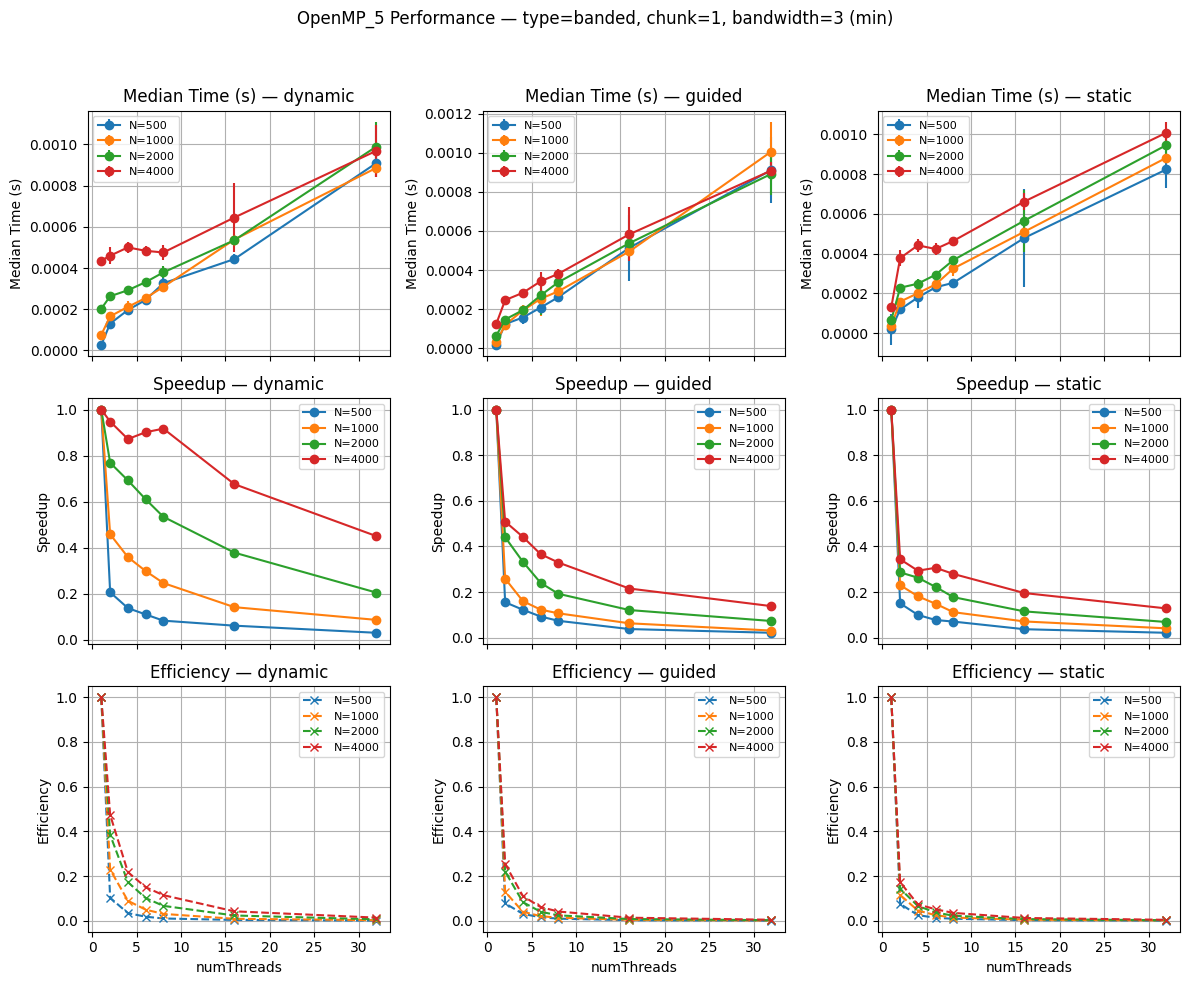

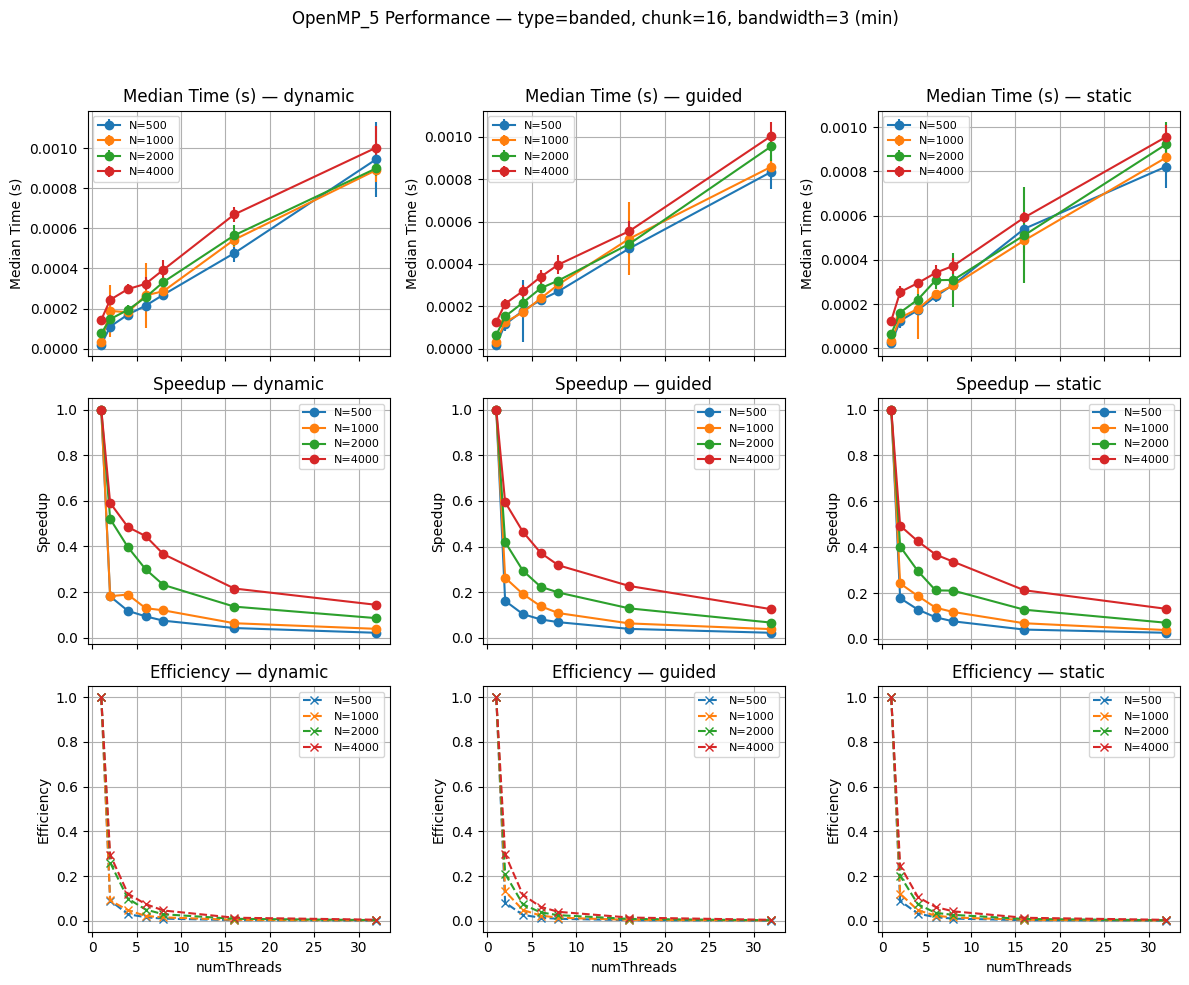

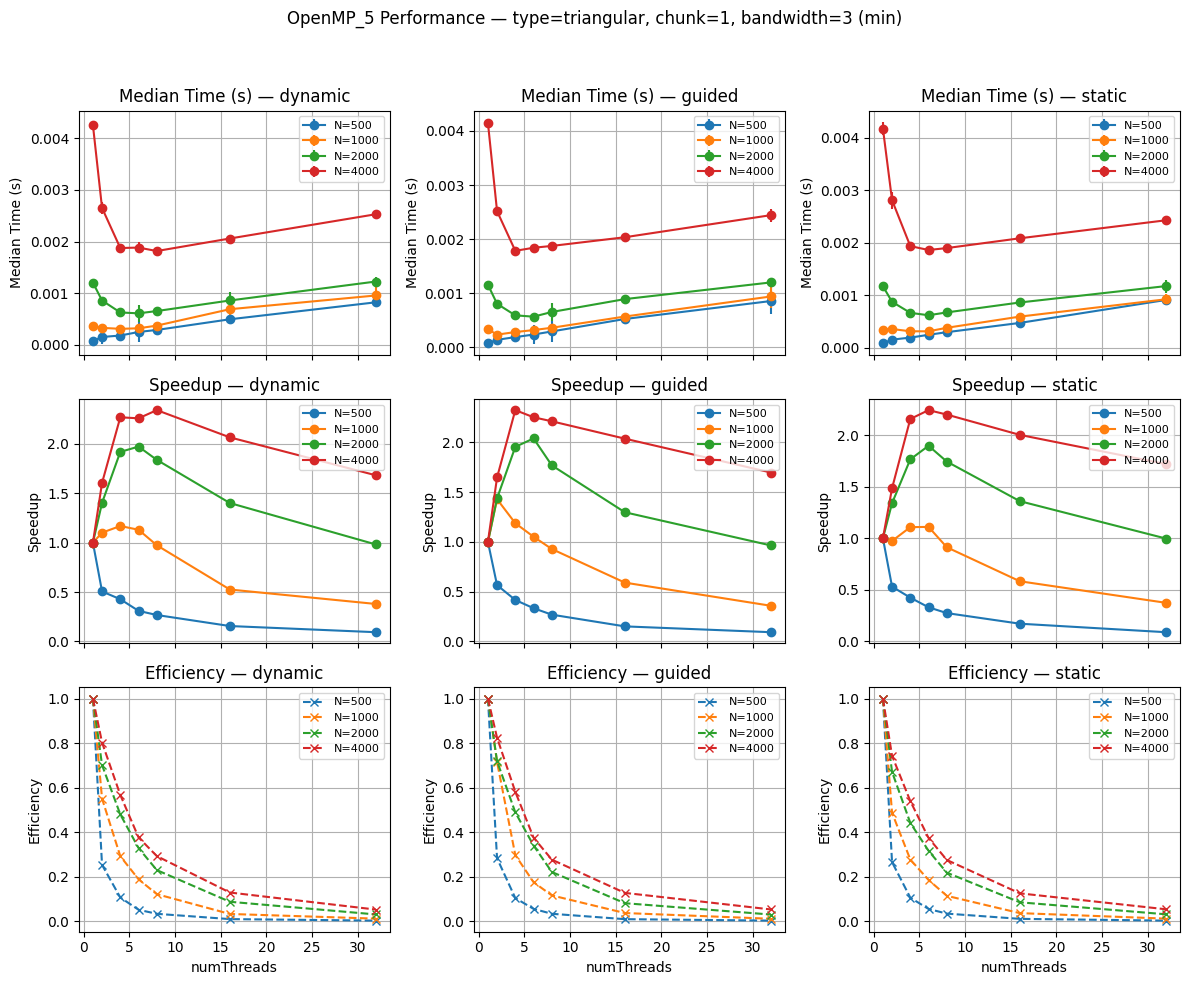

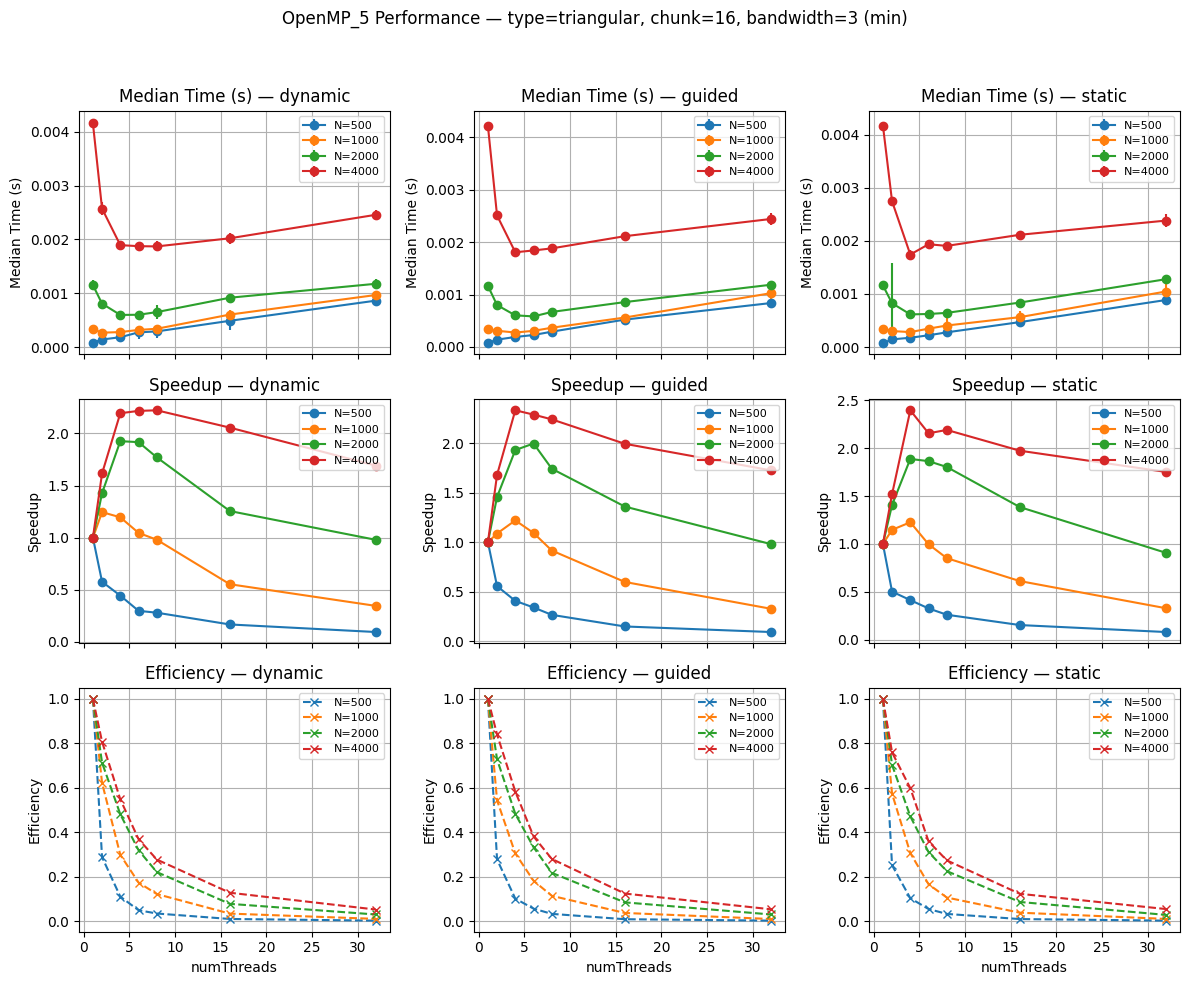

In [54]:
metrics = ["median", "speedup", "efficiency"]
metricLabels = {
    "median": "Median Time (s)",
    "speedup": "Speedup",
    "efficiency": "Efficiency"
}

matrixTypeList = sorted(perfFrame["matrixType"].unique())
chunkList = sorted(perfFrame["chunk"].unique())
schedules = sorted(perfFrame["schedule"].unique())

for matrixTypeVal in matrixTypeList:
    for chunkVal in chunkList:
        filterFrame = perfFrame[(perfFrame["matrixType"] == matrixTypeVal) & (perfFrame["chunk"] == chunkVal)]
        if filterFrame.empty:
            print(f"No data for config: matrixType={matrixTypeVal}, chunk={chunkVal}")
            continue

        numCols = max(1, len(schedules))
        fig, axes = plt.subplots(len(metrics), numCols, figsize=(4 * numCols, 10), sharex=True)

        if len(metrics) == 1 and numCols == 1:
            axes2d = np.array([[axes]])
        elif len(metrics) == 1:
            axes2d = np.array([axes])
        elif numCols == 1:
            axes2d = np.array([[ax] for ax in axes])
        else:
            axes2d = axes

        for colIdx, scheduleVal in enumerate(schedules):
            for rowIdx, metric in enumerate(metrics):
                ax = axes2d[rowIdx][colIdx]
                subForSchedule = filterFrame[filterFrame["schedule"] == scheduleVal]
                if subForSchedule.empty:
                    ax.text(0.5, 0.5, "no data", ha="center", va="center")
                    ax.set_title(f"{scheduleVal}")
                    ax.grid(True)
                    continue

                for matrixSizeVal in sorted(subForSchedule["matrixSize"].unique()):
                    subFrame = subForSchedule[(subForSchedule["matrixSize"] == matrixSizeVal)].sort_values("numThreads")
                    if subFrame.empty:
                        continue

                    x = subFrame["numThreads"].values
                    y = subFrame[metric].values

                    if metric == "median":
                        yerr = subFrame["std"].values
                        ax.errorbar(x, y, yerr=yerr, marker='o', linestyle='-', label=f"N={matrixSizeVal}")
                    else:
                        markerStyle = 'o' if metric == "speedup" else 'x'
                        linestyle = '-' if metric == "speedup" else '--'
                        ax.plot(x, y, marker=markerStyle, linestyle=linestyle, label=f"N={matrixSizeVal}")

                ax.set_title(f"{metricLabels[metric]} — {scheduleVal}")
                if rowIdx == len(metrics) - 1:
                    ax.set_xlabel("numThreads")
                ax.set_ylabel(metricLabels[metric])
                ax.grid(True)
                ax.legend(fontsize=8)

        plt.suptitle(f"OpenMP_5 Performance — type={matrixTypeVal}, chunk={chunkVal}, bandwidth={minBandwidth} (min)")
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


In [57]:
for matrixTypeVal in perfFrame["matrixType"].unique():
    sample = perfFrame[perfFrame["matrixType"] == matrixTypeVal]
    print(f"\n=== matrixType: {matrixTypeVal} — median time (s) ===")
    display(sample.pivot_table(index=["numThreads","schedule","chunk"], columns="matrixSize", values="median"))
    print(f"\n=== matrixType: {matrixTypeVal} — speedup ===")
    display(sample.pivot_table(index=["numThreads","schedule","chunk"], columns="matrixSize", values="speedup"))



=== matrixType: banded — median time (s) ===


matrixSize                     500       1000      2000      4000
numThreads schedule chunk                                        
1          dynamic  1      0.000027  0.000076  0.000202  0.000436
                    16     0.000020  0.000034  0.000077  0.000144
           guided   1      0.000019  0.000031  0.000065  0.000125
                    16     0.000019  0.000033  0.000064  0.000126
           static   1      0.000018  0.000036  0.000065  0.000130
                    16     0.000022  0.000033  0.000065  0.000126
2          dynamic  1      0.000130  0.000166  0.000263  0.000460
                    16     0.000111  0.000189  0.000148  0.000244
           guided   1      0.000124  0.000120  0.000148  0.000247
                    16     0.000115  0.000125  0.000152  0.000212
           static   1      0.000119  0.000158  0.000228  0.000377
                    16     0.000124  0.000138  0.000162  0.000254
4          dynamic  1      0.000196  0.000211  0.000292  0.000500
                    16     0.000170  0.000182  0.000194  0.000297
           guided   1      0.000158  0.000194  0.000196  0.000284
                    16     0.000179  0.000171  0.000217  0.000272
           static   1      0.000179  0.000200  0.000248  0.000441
                    16     0.000172  0.000178  0.000220  0.000295
6          dynamic  1      0.000245  0.000254  0.000331  0.000484
                    16     0.000215  0.000266  0.000256  0.000324
           guided   1      0.000209  0.000253  0.000271  0.000343
                    16     0.000230  0.000237  0.000285  0.000339
           static   1      0.000230  0.000245  0.000293  0.000423
                    16     0.000234  0.000245  0.000308  0.000341
8          dynamic  1      0.000326  0.000309  0.000379  0.000476
                    16     0.000269  0.000287  0.000332  0.000394
           guided   1      0.000262  0.000292  0.000338  0.000381
                    16     0.000271  0.000303  0.000322  0.000397
           static   1      0.000253  0.000325  0.000367  0.000463
                    16     0.000288  0.000285  0.000309  0.000373
16         dynamic  1      0.000443  0.000538  0.000535  0.000645
                    16     0.000476  0.000544  0.000565  0.000669
           guided   1      0.000514  0.000495  0.000538  0.000583
                    16     0.000473  0.000520  0.000495  0.000555
           static   1      0.000478  0.000510  0.000565  0.000662
                    16     0.000541  0.000488  0.000512  0.000592
32         dynamic  1      0.000910  0.000886  0.000989  0.000969
                    16     0.000944  0.000890  0.000899  0.001002
           guided   1      0.000911  0.001006  0.000892  0.000909
                    16     0.000835  0.000859  0.000956  0.001005
           static   1      0.000823  0.000881  0.000945  0.001007
                    16     0.000822  0.000863  0.000923  0.000957


=== matrixType: banded — speedup ===


matrixSize                     500       1000      2000      4000
numThreads schedule chunk                                        
1          dynamic  1      1.000000  1.000000  1.000000  1.000000
                    16     1.000000  1.000000  1.000000  1.000000
           guided   1      1.000000  1.000000  1.000000  1.000000
                    16     1.000000  1.000000  1.000000  1.000000
           static   1      1.000000  1.000000  1.000000  1.000000
                    16     1.000000  1.000000  1.000000  1.000000
2          dynamic  1      0.205521  0.457729  0.768529  0.947826
                    16     0.180832  0.181578  0.520325  0.590574
           guided   1      0.155020  0.258520  0.440081  0.508715
                    16     0.162021  0.263200  0.419567  0.594162
           static   1      0.150800  0.230526  0.286529  0.343858
                    16     0.177653  0.241854  0.402967  0.493711
4          dynamic  1      0.136735  0.358392  0.691992  0.871651
                    16     0.117440  0.188877  0.396694  0.484859
           guided   1      0.122229  0.160144  0.332481  0.441590
                    16     0.104027  0.191949  0.294334  0.464654
           static   1      0.100056  0.181637  0.263094  0.293744
                    16     0.128116  0.187325  0.295692  0.425618
6          dynamic  1      0.109299  0.297956  0.609955  0.901385
                    16     0.093153  0.128996  0.299532  0.445303
           guided   1      0.092477  0.122682  0.240030  0.365996
                    16     0.080905  0.138760  0.223975  0.372381
           static   1      0.077758  0.148814  0.222639  0.306528
                    16     0.094283  0.136215  0.211688  0.368005
8          dynamic  1      0.082183  0.245705  0.533650  0.916930
                    16     0.074267  0.119637  0.231116  0.366108
           guided   1      0.073664  0.106543  0.192137  0.329137
                    16     0.068762  0.108545  0.198571  0.317884
           static   1      0.070835  0.112103  0.177881  0.279612
                    16     0.076709  0.117358  0.210662  0.336549
16         dynamic  1      0.060442  0.140866  0.377944  0.675655
                    16     0.041973  0.063098  0.135857  0.215267
           guided   1      0.037549  0.062765  0.120885  0.215266
                    16     0.039290  0.063318  0.129143  0.227224
           static   1      0.037409  0.071415  0.115514  0.195889
                    16     0.040881  0.068429  0.127468  0.212270
32         dynamic  1      0.029467  0.085553  0.204366  0.449902
                    16     0.021180  0.038522  0.085428  0.143784
           guided   1      0.021176  0.030927  0.072886  0.138094
                    16     0.022267  0.038291  0.066855  0.125572
           static   1      0.021755  0.041298  0.069101  0.128635
                    16     0.026879  0.038689  0.070624  0.131271


=== matrixType: triangular — median time (s) ===


matrixSize                     500       1000      2000      4000
numThreads schedule chunk                                        
1          dynamic  1      0.000077  0.000363  0.001205  0.004255
                    16     0.000082  0.000335  0.001153  0.004157
           guided   1      0.000079  0.000337  0.001158  0.004149
                    16     0.000078  0.000336  0.001165  0.004215
           static   1      0.000080  0.000344  0.001169  0.004174
                    16     0.000073  0.000345  0.001160  0.004170
2          dynamic  1      0.000153  0.000330  0.000859  0.002651
                    16     0.000142  0.000269  0.000808  0.002574
           guided   1      0.000140  0.000236  0.000806  0.002517
                    16     0.000140  0.000309  0.000799  0.002508
           static   1      0.000151  0.000353  0.000872  0.002809
                    16     0.000144  0.000301  0.000825  0.002745
4          dynamic  1      0.000181  0.000311  0.000628  0.001875
                    16     0.000185  0.000280  0.000599  0.001895
           guided   1      0.000190  0.000284  0.000592  0.001784
                    16     0.000191  0.000275  0.000603  0.001807
           static   1      0.000189  0.000310  0.000662  0.001934
                    16     0.000175  0.000282  0.000615  0.001742
6          dynamic  1      0.000250  0.000321  0.000611  0.001884
                    16     0.000275  0.000320  0.000602  0.001876
           guided   1      0.000237  0.000320  0.000568  0.001841
                    16     0.000228  0.000307  0.000583  0.001841
           static   1      0.000243  0.000310  0.000616  0.001860
                    16     0.000221  0.000346  0.000623  0.001936
8          dynamic  1      0.000289  0.000373  0.000655  0.001817
                    16     0.000292  0.000342  0.000651  0.001871
           guided   1      0.000295  0.000363  0.000655  0.001875
                    16     0.000292  0.000367  0.000668  0.001881
           static   1      0.000293  0.000377  0.000670  0.001896
                    16     0.000277  0.000405  0.000643  0.001905
16         dynamic  1      0.000496  0.000691  0.000860  0.002060
                    16     0.000490  0.000605  0.000918  0.002023
           guided   1      0.000525  0.000570  0.000892  0.002035
                    16     0.000522  0.000562  0.000856  0.002113
           static   1      0.000470  0.000590  0.000859  0.002083
                    16     0.000469  0.000563  0.000838  0.002114
32         dynamic  1      0.000825  0.000957  0.001227  0.002530
                    16     0.000864  0.000969  0.001177  0.002459
           guided   1      0.000857  0.000941  0.001200  0.002443
                    16     0.000838  0.001026  0.001187  0.002442
           static   1      0.000907  0.000920  0.001172  0.002426
                    16     0.000886  0.001046  0.001277  0.002381


=== matrixType: triangular — speedup ===


matrixSize                     500       1000      2000      4000
numThreads schedule chunk                                        
1          dynamic  1      1.000000  1.000000  1.000000  1.000000
                    16     1.000000  1.000000  1.000000  1.000000
           guided   1      1.000000  1.000000  1.000000  1.000000
                    16     1.000000  1.000000  1.000000  1.000000
           static   1      1.000000  1.000000  1.000000  1.000000
                    16     1.000000  1.000000  1.000000  1.000000
2          dynamic  1      0.506205  1.101243  1.402818  1.605176
                    16     0.576761  1.244701  1.426309  1.615208
           guided   1      0.565714  1.429966  1.437934  1.648169
                    16     0.556192  1.088026  1.457150  1.680553
           static   1      0.530734  0.974228  1.341172  1.485851
                    16     0.503467  1.147508  1.406474  1.519086
4          dynamic  1      0.427704  1.168543  1.918764  2.268849
                    16     0.443902  1.194930  1.925171  2.193268
           guided   1      0.416404  1.188360  1.956096  2.325468
                    16     0.407446  1.220770  1.931509  2.333130
           static   1      0.423747  1.108247  1.766546  2.158325
                    16     0.414620  1.226562  1.886811  2.394087
6          dynamic  1      0.309876  1.130719  1.972168  2.258493
                    16     0.297927  1.045611  1.915891  2.215595
           guided   1      0.333614  1.052155  2.040514  2.253721
                    16     0.340789  1.093333  1.997428  2.289539
           static   1      0.330317  1.110752  1.898198  2.244314
                    16     0.328061  0.997113  1.863775  2.154406
8          dynamic  1      0.267888  0.973734  1.837962  2.341386
                    16     0.280096  0.979801  1.769691  2.221278
           guided   1      0.268748  0.928867  1.769901  2.213207
                    16     0.266187  0.916076  1.742519  2.241453
           static   1      0.273874  0.912951  1.744665  2.201118
                    16     0.262189  0.851998  1.802953  2.189354
16         dynamic  1      0.156345  0.525836  1.401186  2.065835
                    16     0.167314  0.553223  1.255145  2.055124
           guided   1      0.150943  0.591053  1.298509  2.038669
                    16     0.148879  0.598647  1.360472  1.994748
           static   1      0.170960  0.583051  1.360526  2.004033
                    16     0.154633  0.613281  1.384817  1.972707
32         dynamic  1      0.093985  0.379663  0.981824  1.681951
                    16     0.094770  0.345443  0.978937  1.690415
           guided   1      0.092459  0.358138  0.964931  1.698224
                    16     0.092754  0.327776  0.981296  1.726461
           static   1      0.088514  0.373913  0.997951  1.720610
                    16     0.081988  0.330337  0.908322  1.751501

In [58]:
summaryRows = []
for (matrixTypeVal, matrixSizeVal, scheduleVal, chunkVal), sub in perfFrame.groupby(["matrixType","matrixSize","schedule","chunk"]):
    maxSpeedup = sub["speedup"].max()
    argMax = sub.loc[sub["speedup"].idxmax()]
    bestThreads = int(argMax["numThreads"])
    effAtBest = float(argMax["efficiency"])
    medianAtOne = sub.loc[sub["numThreads"]==1, "median"]
    medianAtOne = float(medianAtOne.values[0]) if not medianAtOne.empty else np.nan
    summaryRows.append({
        "matrixType": matrixTypeVal,
        "matrixSize": matrixSizeVal,
        "schedule": scheduleVal,
        "chunk": chunkVal,
        "bestNumThreads": bestThreads,
        "maxSpeedup": maxSpeedup,
        "efficiencyAtBest": effAtBest,
        "medianTime1Thread": medianAtOne
    })

summaryAnalysisFrame = pd.DataFrame(summaryRows).sort_values(["matrixType","matrixSize","schedule","chunk"])
display(summaryAnalysisFrame)


,matrixType,matrixSize,schedule,chunk,bestNumThreads,maxSpeedup,efficiencyAtBest,medianTime1Thread
0,banded,500,dynamic,1,1,1.000000,1.000000,0.000027
1,banded,500,dynamic,16,1,1.000000,1.000000,0.000020
2,banded,500,guided,1,1,1.000000,1.000000,0.000019
3,banded,500,guided,16,1,1.000000,1.000000,0.000019
4,banded,500,static,1,1,1.000000,1.000000,0.000018
5,banded,500,static,16,1,1.000000,1.000000,0.000022
6,banded,1000,dynamic,1,1,1.000000,1.000000,0.000076
7,banded,1000,dynamic,16,1,1.000000,1.000000,0.000034
8,banded,1000,guided,1,1,1.000000,1.000000,0.000031
9,banded,1000,guided,16,1,1.000000,1.000000,0.000033
